In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os

In [2]:
!pwd

/home/dsc/TFM/repositorio


In [3]:
data_root = "/home/dsc/TFM/repositorio/"

In [4]:
columns = ['user_id', 'rating', 'comida', 'id_comida' ]
datafile = os.path.join(data_root, "Encuesta_vf.csv")
data = pd.read_csv(datafile, sep=';', header =0, names=columns, encoding='latin-1')
data.head()

,user_id,rating,comida,id_comida
0,18,3,Ensalada de col con queso,4
1,33,1,Ensalada de col con queso,4
2,63,1,Ensalada de col con queso,4
3,64,2,Ensalada de col con queso,4
4,65,1,Ensalada de col con queso,4


In [5]:
n_users = data.user_id.unique().shape[0]
n_items = data.comida.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

1084 users
407 items


In [6]:
items_id = {}
food = data.comida.unique()
food_id = {}
n = 0
for x in food:
    items_id[x] = n
    food_id[n] = x
    n += 1

In [7]:
items_id['Puchero casero']

110

In [8]:
index = list(range(len(data.index)))

In [9]:
column_items_id=[]
for x in index:
    column_items_id.append(items_id[data['comida'][x]]) 

In [10]:
data['items_id'] = column_items_id

In [11]:
data.head()

,user_id,rating,comida,id_comida,items_id
0,18,3,Ensalada de col con queso,4,0
1,33,1,Ensalada de col con queso,4,0
2,63,1,Ensalada de col con queso,4,0
3,64,2,Ensalada de col con queso,4,0
4,65,1,Ensalada de col con queso,4,0


In [12]:
p_train = 0.70 # Porcentaje de train.

data['is_train'] = np.random.uniform(0, 1, len(data)) <= p_train
train, test = data[data['is_train']==True], data[data['is_train']==False]
data = data.drop('is_train', 1)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para test: ", len(test))

Ejemplos usados para entrenar:  28901
Ejemplos usados para test:  12613


In [13]:
ratings = np.zeros((n_users, n_items))
n_rating = len(train) + len(test)
sparsity = n_rating/(ratings.shape[0] * ratings.shape[1])
sparsity *=100
print (sparsity)

9.40959409594096


In [14]:
train.head()

,user_id,rating,comida,id_comida,items_id,is_train
0,18,3,Ensalada de col con queso,4,0,True
1,33,1,Ensalada de col con queso,4,0,True
4,65,1,Ensalada de col con queso,4,0,True
5,66,3,Ensalada de col con queso,4,0,True
6,70,1,Ensalada de col con queso,4,0,True


In [15]:
data_top=(data[data.rating>2])

In [16]:
data_untop=(data[data.rating<=2])

In [17]:
foodPerUser1 = (data_top.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [18]:
# Matriz de coocurrencia de los que le gustan
coMatrix_top = np.zeros((n_items, n_items))
for food in foodPerUser1.values():
    for x in food:
        coMatrix_top[x, food] += 1

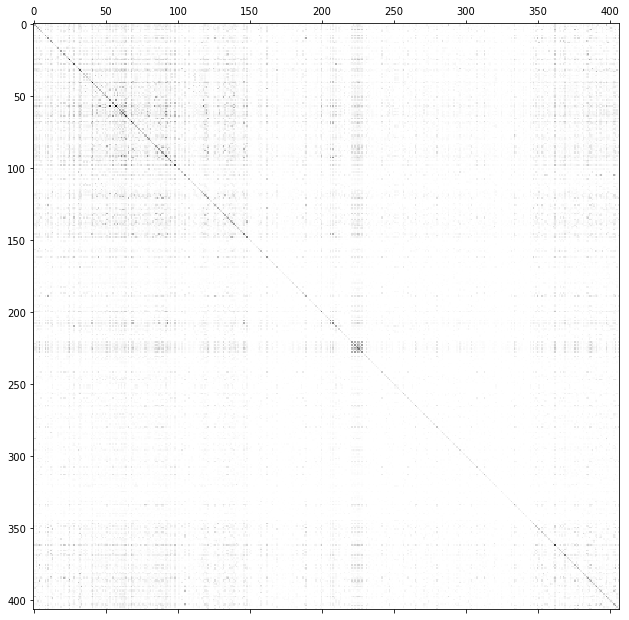

In [19]:
plt.matshow(coMatrix_top, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [20]:
foodPerUser2 = (data_untop.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [21]:
# # Matriz de coocurrencia de los que NO le gustan
coMatrix2 = np.zeros((n_items, n_items))
for food in foodPerUser2.values():
    for x in food:
        coMatrix2[x, food] += 1

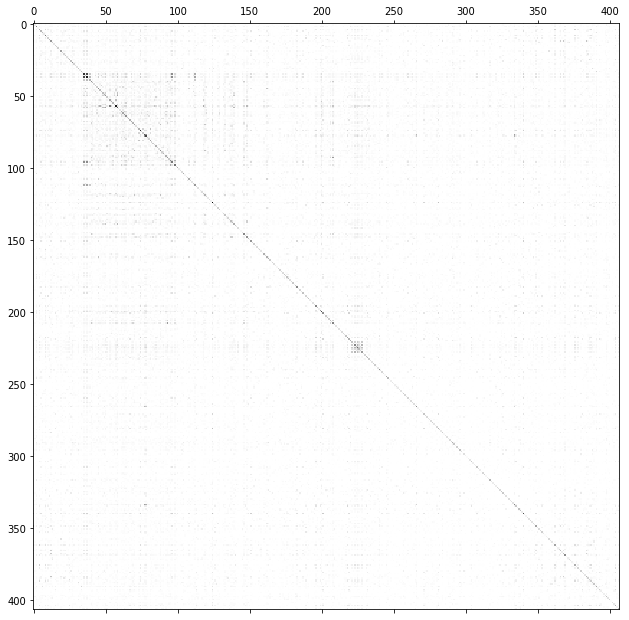

In [22]:
plt.matshow(coMatrix2, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

#Ntop similarity

In [23]:
train_top=(train[train.rating>2])

In [24]:
foodPerUser = (train_top.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [25]:
coMatrix_top_train = np.zeros((n_items, n_items))
for food in foodPerUser.values():
    for x in food:
        coMatrix_top_train[x, food] += 1

In [26]:
coMatrix_top_train

array([[111.,  11.,  17., ...,  15.,   3.,   1.],
       [ 11.,  86.,   8., ...,   1.,   2.,   0.],
       [ 17.,   8., 123., ...,   3.,   0.,   0.],
       ...,
       [ 15.,   1.,   3., ..., 113.,   6.,  18.],
       [  3.,   2.,   0., ...,   6.,  45.,   4.],
       [  1.,   0.,   0., ...,  18.,   4.,  47.]])

In [27]:
def co_occurrance_similarity(item_id, coocurrance, ntop=10):
    """
    Retorna los ntop más similares según la matriz coocurrencia
    """
    similarItems = coocurrance[item_id, :]
    mostSimilar = np.argsort(similarItems)[::-1]
    mostSimilar = mostSimilar[1:ntop+1]
    

    return np.stack((mostSimilar, similarItems[mostSimilar])).T

In [28]:
co_occurrance_similarity(122, coMatrix_top_train, 10)

array([[ 31.,  29.],
       [125.,  22.],
       [ 68.,  15.],
       [388.,  14.],
       [140.,  13.],
       [225.,  12.],
       [129.,  12.],
       [ 61.,  11.],
       [ 32.,  11.],
       [ 62.,  11.]])

In [29]:
column_items_id[122]

0

In [30]:
FoodId = 1
Ntop = 5
print('For item "%s" top-%s recommendations are:' % (food_id[FoodId], Ntop))

similarItems = co_occurrance_similarity(FoodId, coMatrix_top_train, Ntop)

for r in similarItems:
    print(int(r[0]), food_id[int(r[0])], r[1])

For item "Ensalada de tomate y pimiento asado" top-5 recommendations are:
288 Canelones con Verduras 42.0
398 Tortilla de Pimientos y Cebolla 41.0
200 Empanadas argentinas 26.0
362 Verduras salteadas con soja 25.0
226 Mero a la parrilla 24.0


In [31]:
def co_occurrance_recommendation(items_id, cooccurrance, ntop=10):
    """
    Devuelve la lista ntop recomendacciones, en base a un items_id y una matriz de coocurrencia
    
    """
    
    list_sim_items = np.vstack([co_occurrance_similarity(id_, cooccurrance, ntop) for id_ in items_id])
    
    largest_freq = pd.DataFrame(list_sim_items, columns=['id', 'freq']).groupby('id').agg(max).reset_index()
    
    sorted_list = largest_freq.sort_values(by='freq', ascending=False)
    
    out = sorted_list.values[:ntop, 0]
    return out
    

In [32]:
Ntop = 200

In [33]:
trainUsersGrouped = train.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
train_ids = trainUsersGrouped.items_id.values
testUsersGrouped = test.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
test_ids = testUsersGrouped.items_id.values

predictions = trainUsersGrouped.items_id.apply(lambda x: co_occurrance_recommendation(x, coMatrix_top_train, Ntop)).reset_index()
predictions.head()

,index,items_id
0,0,"[92.0, 41.0, 226.0, 223.0, 225.0, 228.0, 61.0,..."
1,1,"[41.0, 223.0, 225.0, 226.0, 228.0, 92.0, 61.0,..."
2,2,"[92.0, 61.0, 95.0, 50.0, 139.0, 68.0, 41.0, 64..."
3,3,"[61.0, 63.0, 79.0, 93.0, 208.0, 146.0, 41.0, 6..."
4,4,"[57.0, 226.0, 225.0, 223.0, 93.0, 208.0, 386.0..."


In [34]:
len(predictions['items_id'][0])

200

In [35]:
#Evaluate Recomendation

In [36]:
class Metrics():
    """
    Implement the two most important relevance's metric for RS:
        . Recall
        . MAP
    """
    def __init__(self, train_ids, test_ids, recommended_ids):
        
        self.zipped = list(zip(test_ids, train_ids, recommended_ids))
        
    def recall_per_user(self, N, test, recommended, train):
        """
        :param N: number of recommendations
        :param test: list of movies seen by user in test
        :param recommended: list of movies recommended

        :return the recall
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
            else:
                rec_true = recommended   
        intersection = len(set(test) & set(rec_true[:N]))
        return intersection / float(np.minimum(N, len(test)))
       
    def recall_at_n(self, topN):
        """
        Computes the mean recall@k, for k in topN
        :param topN: list of positions
        """
        out = []
        for k in topN:
            recall = np.mean([self.recall_per_user(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(recall)
            print("recall@%s=%.3f" %(k, recall))
        return out
                                       
    def apk(self, N, test, recommended, train):
        """
        Computes the average precision at N given recommendations.

        :param N: number of recommendations
        :param test: list of movies seen by user in test
        :param recommended: list of movies recommended

        :return The average precision at N over the test set
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
        else:
            rec_true = recommended    
        predicted = rec_true[:N] # top-k predictions

        score = 0.0 
        num_hits = 0.0 

        for i,p in enumerate(predicted):
            if p in test and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits/(i+1.0)

        return score / min(len(test), N)

    def map_at_n(self, topN):
        """
        Computes the mean average precision at k, for k in topN
        :param topN: list of positions
        """
        out = []
        for k in topN:
            map_ = np.mean([self.apk(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(map_)
            print("map@%s=%.3f" %(k, map_))
        return out

In [37]:
topk = [5, 10, 20, 30, 50]
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
_ = m.recall_at_n(topk)


recall@5=0.221
recall@10=0.212
recall@20=0.281
recall@30=0.377
recall@50=0.492


In [38]:
_ = m.map_at_n(topk)

map@5=0.266
map@10=0.189
map@20=0.189
map@30=0.205
map@50=0.219


In [39]:
testUsersGrouped['items_id'][10]

[40, 71, 105, 124, 138, 208, 281, 337, 356, 378, 383, 394]

In [40]:
data.head()

,user_id,rating,comida,id_comida,items_id
0,18,3,Ensalada de col con queso,4,0
1,33,1,Ensalada de col con queso,4,0
2,63,1,Ensalada de col con queso,4,0
3,64,2,Ensalada de col con queso,4,0
4,65,1,Ensalada de col con queso,4,0


In [41]:
##  Jaccard similarity matrix

In [42]:
jaccard = np.zeros((n_items, n_items)) # Jaccard similarity matrix
for i, row in enumerate(coMatrix_top_train):
    if row[i]!=0: # Case where the diagonal is not empty, i.e. coM(i,i)!=0
        jaccard[i,:] = row/(row[i]+np.diag(coMatrix_top_train)-row)
    else: # case where the diagonal is empty. We have to aasign a similarity of 1 to item pairs without ratings
        for j in np.arange(n_items):
            if coMatrix_top_train[j,j]==0:
                jaccard[i,j] = 1.0
            else: 
                jaccard[i,j] = 0.0

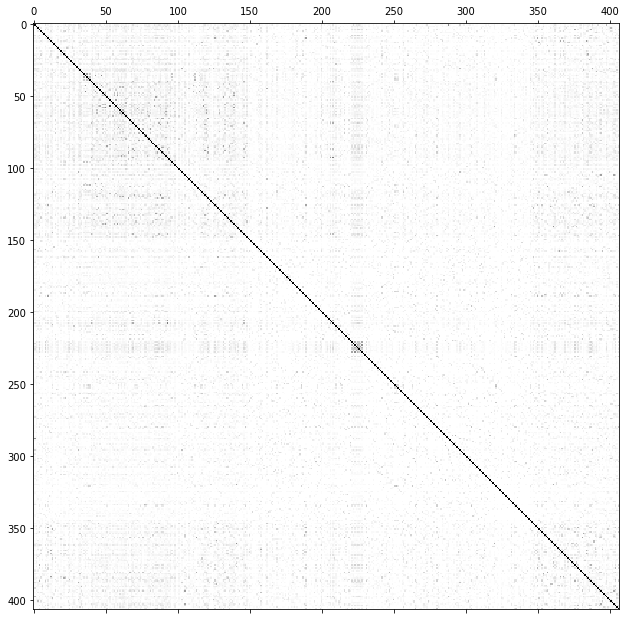

In [43]:
plt.matshow(jaccard, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [44]:
Ntop = 200
# Calculate the predictoins with Jaccard
predictions = trainUsersGrouped.items_id.apply(lambda x: co_occurrance_recommendation(x, jaccard, Ntop)).reset_index()
predictions.head()

,index,items_id
0,0,"[228.0, 50.0, 58.0, 139.0, 85.0, 132.0, 51.0, ..."
1,1,"[228.0, 58.0, 50.0, 139.0, 51.0, 85.0, 132.0, ..."
2,2,"[50.0, 139.0, 127.0, 56.0, 401.0, 61.0, 359.0,..."
3,3,"[288.0, 93.0, 394.0, 59.0, 72.0, 61.0, 403.0, ..."
4,4,"[223.0, 88.0, 93.0, 57.0, 365.0, 228.0, 221.0,..."


In [45]:
topk = [5, 10, 20, 30, 50]
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
_ = m.recall_at_n(topk)

recall@5=0.250
recall@10=0.245
recall@20=0.360
recall@30=0.481
recall@50=0.603


In [46]:
_ = m.map_at_n(topk)

map@5=0.423
map@10=0.323
map@20=0.327
map@30=0.346
map@50=0.361


In [47]:
# Memory Based in Collaborate Filter

In [48]:
uMatrixTraining = np.zeros((n_users, n_items)) # utility matrix
for row in train.values[:,0:5]:
    user = row[0]-1 #for use the same as index
    item = row[4]
    rating = row[1]
    uMatrixTraining[user, item] = rating

In [49]:
uMatrixTesting = np.zeros((n_users, n_items)) # utility matrix
for row in test.values[:,0:5]:
    # Note user ids start at 1
    user = row[0]-1
    item = row[4]
    rating = row[1]
    uMatrixTesting[user, item] = rating

In [50]:
def cosineSimilarity(ratings, kind='user', epsilon=1e-9):
    """
    Calculate the cosine distance along the row (columns) of a matrix for users (items)
    
    :param ratings: a n_user X n_items matrix
    :param kind: string indicating whether we are in mode 'user' or 'item'
    :param epsilon: a small value to avoid dividing by zero (optional, defaults to 1e-9)
    
    :return a square matrix with the similarities
    """
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T)+epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings)+epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T


USER - USER

In [51]:
userSimilarity = cosineSimilarity(uMatrixTraining, kind='user')

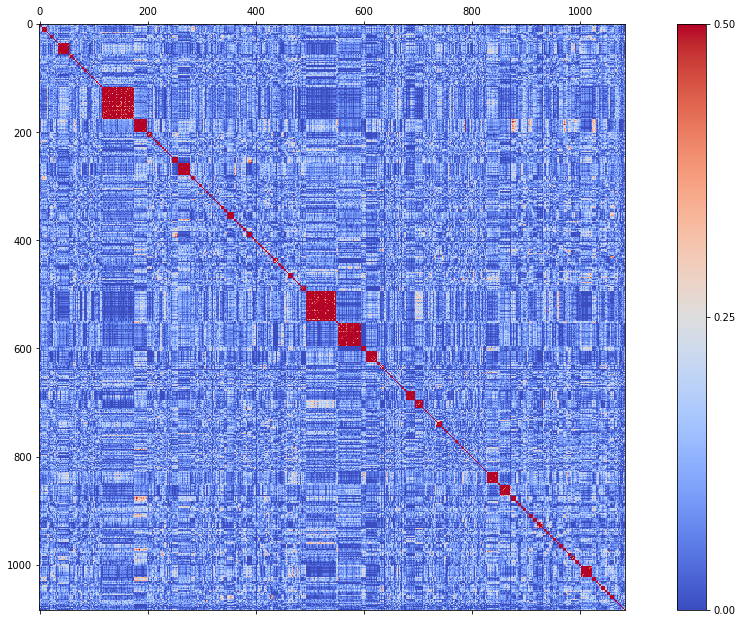

In [52]:
cax = plt.matshow(userSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [53]:
norm = np.array([userSimilarity.sum(axis=1)]).T
userItemCFpredictions = userSimilarity.dot(uMatrixTraining) / norm

### Item-Item

In [54]:
itemSimilarity = cosineSimilarity(uMatrixTraining, kind='item')

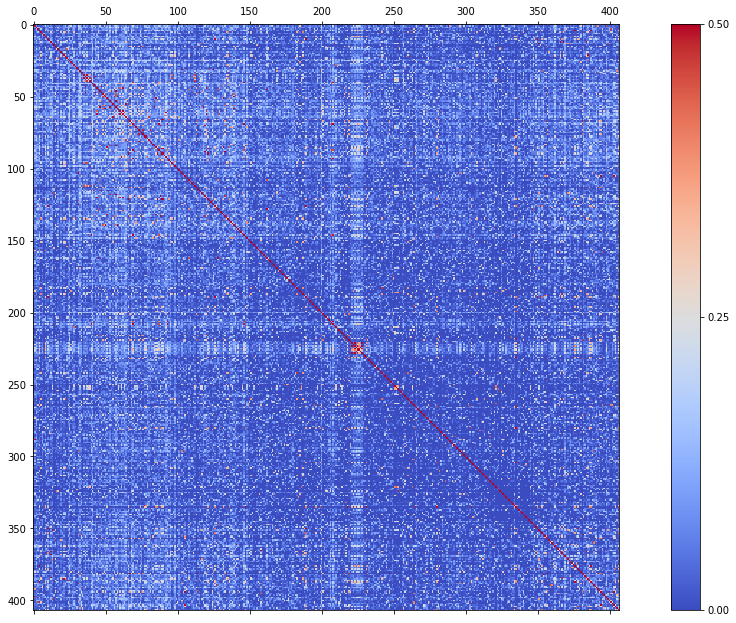

In [55]:
cax = plt.matshow(itemSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [56]:
itemItemCFpredictions = uMatrixTraining.dot(itemSimilarity)/np.array([np.abs(itemSimilarity).sum(axis=1)])

In [57]:
query_Id = 300
print("Selected item is '%s'" % food_id[query_Id])


queryAnswer = np.argsort(itemSimilarity[query_Id,:])[::-1][1:]

Ntop = 10
print("Most %d similar food are:" %Ntop)
printAnswer = queryAnswer[0:Ntop]
for answerId in printAnswer:
    print(food_id[answerId]+", with similarity %.2f" %itemSimilarity[query_Id, answerId])

Selected item is 'Raviolis rellenos de setas'
Most 10 similar food are:
Arroz frito con curry, with similarity 0.18
Puré de Arvejas o Guisantes, with similarity 0.17
Pizza con piña hawaiana, with similarity 0.16
Huevos revueltos con champiñones, with similarity 0.16
Ensaladilla rusa para el verano, with similarity 0.15
Guisantes con huevo, with similarity 0.15
Ternera asada con patatas nuevas, with similarity 0.13
Estofado de pollo con patatas, with similarity 0.13
Pizza Fugazza con Queso, with similarity 0.12
Pollo Empanado al Horno, with similarity 0.12


In [58]:
itemItemCFpredictions[uMatrixTraining>=2.0] = 0.0
for u in np.random.randint(0, n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Items: ")
    seen = uMatrixTesting[u,:]
    print([food_id[i] for i,r in enumerate(seen) if r>2.0])
    print("Recommended items: ")
    recom = itemItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([food_id[i] for i in recom])

******
User 526
Items: 
['Acelgas con Patatas y Pimentón', 'Redondo de ternera al horno', 'Pizza queso, champiñones y jamón york', 'Verduras salteadas con soja']
Recommended items: 
['Tallarines a la carbonara', 'Sándwich de atún', 'Pizza queso, champiñones y jamón york', 'Redondo de ternera al horno', 'Pechugas de pollo con nata', 'Lomo de cerdo en salsa de manzana', 'Acelgas con Patatas y Pimentón', 'Salmón en salsa de queso', 'Salchichas en salsa de tomate', 'Merluza rebozada']
******
User 306
Items: 
['Ensalada de berros con tomate', 'Empedrat de garbanzos', 'Ensalada de maíz y aguacate', 'Ternera asada al horno', 'Estofado de Ternera con Verduras', 'Merluza con espárragos al horno', 'Lasaña de espinacas y atún', 'Acelgas salteadas con patata']
Recommended items: 
['Pizza con piña hawaiana', 'Puré de Papas al Horno', 'Menestra de fréjol', 'Arroz frito con pollo', 'Coles de bruselas con bechamel al horno', 'Tortilla de brócoli y coliflor', 'Espárragos gratinados', 'Pollo en salsa de

In [59]:
userItemCFpredictions[uMatrixTraining>=2.0] = 0.0
for u in np.random.randint(0, n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Seen items: ")
    seen = uMatrixTesting[u,:]
    print([food_id[i] for i,r in enumerate(seen) if r>2.0])
    print("Recommended items: ")
    recom = userItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([food_id[i] for i in recom])

******
User 362
Seen items: 
['Ensalada de calabaza', 'Conejo a la plancha', 'Pollo en salsa de soja y miel', 'Cabrito a la Plancha', 'Cabrito en salsa de almendras', 'Lomo de cerdo al horno', 'Canelones con Verduras', 'Arroz con Salchichas']
Recommended items: 
['Merluza rebozada', 'Ensalada de maíz y aguacate', 'Alambre de res con champiñones', 'Churrasco a la brasa', 'Lomo de cerdo al horno', 'Mero a la parrilla', 'Ternera a la jardinera', 'Empanadas argentinas', 'Guiso de ternera con garbanzos', 'Carne en salsa fácil']
******
User 294
Seen items: 
['Acelgas con Patatas y Pimentón', 'Churrasco a la brasa', 'Cabrito en salsa de almendras', 'Estofado de Ternera con Verduras', 'Guiso de ternera con garbanzos', 'Ternera asada con patatas nuevas', 'Quiché de puerros y queso de cabra', 'Sándwich de pernil', 'Pizza Fugazza con Queso', 'Arroz cremoso con calabacín', 'Croquetas de calabacín y queso']
Recommended items: 
['Churrasco a la brasa', 'Ensalada de maíz y aguacate', 'Alambre de res 

In [60]:
from math import sqrt
def rmse(prediction, ground_truth):
    """
    Return the Root Mean Squared Error of the prediction
    """
    r, c = ground_truth.nonzero()
    p = prediction[r,c]
    t = ground_truth[r,c]
    return sqrt(np.mean(np.power(p-t, 2.0)))

In [61]:
print('User-based CF RMSE=%.3f' %rmse(userItemCFpredictions, uMatrixTesting))

User-based CF RMSE=2.786


In [62]:
print('Item-based CF RMSE=%.3f' %rmse(itemItemCFpredictions, uMatrixTesting))

Item-based CF RMSE=2.814


In [63]:
itemItemCFpredictions_sorted = np.argsort(itemItemCFpredictions)[:, ::-1]

test_ids = testUsersGrouped.items_id.values
train_ids = trainUsersGrouped.items_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: itemItemCFpredictions_sorted[i-1]).values
topk = [5, 10, 20, 30, 50]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)


*****Recall*****
recall@5=0.407
recall@10=0.395
recall@20=0.493
recall@30=0.575
recall@50=0.665
*****Map*****
map@5=0.461
map@10=0.397
map@20=0.400
map@30=0.417
map@50=0.431


In [64]:
userItemCFpredictions_sorted = np.argsort(userItemCFpredictions)[:, ::-1]

test_ids = testUsersGrouped.items_id.values
train_ids = trainUsersGrouped.items_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: userItemCFpredictions_sorted[i-1]).values
topk = [5, 10, 20, 30, 50]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)


*****Recall*****
recall@5=0.354
recall@10=0.321
recall@20=0.412
recall@30=0.498
recall@50=0.595
*****Map*****
map@5=0.309
map@10=0.251
map@20=0.259
map@30=0.279
map@50=0.294
